# Adversarial Attacks and Robustness ｜ FGSM

This tutorial demonstrates how to use the **fast gradient sign method  (FSGM)** [1] to generate adversarial examples for handwritten digit classification on the [MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) dataset. 

<!-- Use this command to show the figure if you are offline. -->
<!-- <img src="Util/demo2_1.jpg" alt="white-box attack" width="500"/> -->

<img src="https://github.com/siyi-wind/ELEC70121_TAIMI_2025/raw/main/Util/demo2_1.jpg" alt="Alt text" width="500">

In this tutorial, we will cover the following topics

- Prepare the dataset and model

- Train the model

- FSGM

    - Define FSGM

    - Generate adversarial examples through FSGM
    
    - Evaluate the attack performance

<br>

**Note**: To use Google Colab's GPU, click 'Runtime' --> 'Change runtime type' -->  'T4 GPU'

The tutorial is based on [this repository](https://github.com/trustworthy-ml-course/trustworthy-ml-course.github.io/blob/main/demos/Demo-2.ipynb).

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.
[2] 

### Step 1: Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# # TODO If you use Google Colab, uncomment the following code
# from google.colab import drive
# drive.mount('/content/gdrive')

# # Change to the path of the tutorial
# import os
# path = './gdrive/MyDrive/Code/ic/TAIMI_trustworthy' 
# os.chdir(path)

### Step 2: Prepare the MNIST Dataset

In [2]:
# Transform for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='Data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='Data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### Step 3: Define the Model

In [4]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = DNN()
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

### Step 4: Train the Model

Define the loss function and optimizer, and train the model on the dataset.

In [5]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0148
Epoch [2/10], Loss: 0.3194
Epoch [3/10], Loss: 0.0064
Epoch [4/10], Loss: 0.0386
Epoch [5/10], Loss: 0.2407
Epoch [6/10], Loss: 0.0008
Epoch [7/10], Loss: 0.0915
Epoch [8/10], Loss: 0.0010
Epoch [9/10], Loss: 0.0250
Epoch [10/10], Loss: 0.0001


In [6]:
# Test the model before attacking
model.eval()
with torch.no_grad():
    correct, total = 0, 0  # Initialize the number of correct predictions and the total number of images
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 98.12%


### Step 5: [TODO] Define the FGSM Attack

The FGSM attack perturbs input in the direction of the sign of the gradient of the loss w.r.t. the input, scaled by a perturbation budget.

<!-- Use this command to show the figure if you are offline. -->
<!-- <img src="Util/demo2_2.jpg" alt="FGSM" width="600"/> -->

<img src="https://github.com/siyi-wind/ELEC70121_TAIMI_2025/raw/main/Util/demo2_2.jpg" alt="Alt text" width="600">

Here $\epsilon$ represents the magnitude of the perturbation

In [7]:
def FGSM_attack(model, image, label, epsilon):

    image.requires_grad = True # since we're acting on the image
    model.zero_grad()

    output = model(image)
    loss = criterion(output, label)
    loss.backward()

    _, init_pred = torch.max(output.detach(), 1)

    # TODO: Implement the FGSM attack
    perturbed_image = image + epsilon * image.grad.sign()
    perturbed_image = torch.clamp(perturbed_image, 0, 1) # clip to ensure pixel values stay in the normalized [0,1] range
    return init_pred, perturbed_image

### Step 6: Evaluate FGSM Attack

Test the model on adversarial examples generated using FGSM.

In [8]:
def test_FGSM(model, device, test_loader, epsilon):
    model.eval()
    correct = 0
    total = 0
    adv_examples = []   

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        # Generate adversarial examples
        init_pred, x_adv = FGSM_attack(model,x,y,epsilon)

        output = model(x_adv)
        _, final_pred = torch.max(output, 1)

        correct += (final_pred == y).sum().item()
        total += y.size(0)

        # save a few adversarial examples for visualization. Only save the samples where the model has correctly classified the original image 
        if init_pred.item() == y.item() and len(adv_examples) < 10:
            adv_ex = x_adv.squeeze().detach().cpu().numpy()
            adv_examples.append((y.cpu(), init_pred.item(), final_pred.item(), x.squeeze().detach().cpu().numpy(), adv_ex))
    
    final_acc = correct / total
    print('Done running FGSM on', total, f'test samples, with epsilon = {epsilon:.2f}', f'| Accuracy: {final_acc:.4f}')
    return final_acc, adv_examples

In [9]:
# Test different epsilon values. epsilon = 0.00 is the model's accuracy without any attack
epsilons = [0.00, 0.05, 0.10, 0.15, 0.20]
accuracies = []
examples = []
test_dataloader_FGSM = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

for eps in epsilons:
    acc, ex = test_FGSM(model, device, test_dataloader_FGSM, eps)
    accuracies.append(acc)
    examples.append(ex)

Done running FGSM on 10000 test samples, with epsilon = 0.00 | Accuracy: 0.9812
Done running FGSM on 10000 test samples, with epsilon = 0.05 | Accuracy: 0.7219
Done running FGSM on 10000 test samples, with epsilon = 0.10 | Accuracy: 0.3184
Done running FGSM on 10000 test samples, with epsilon = 0.15 | Accuracy: 0.1342
Done running FGSM on 10000 test samples, with epsilon = 0.20 | Accuracy: 0.0578


### Step 7: Visualize Results

Visualize the accuracy drop and the adversarial examples w.r.t different epsilon values.

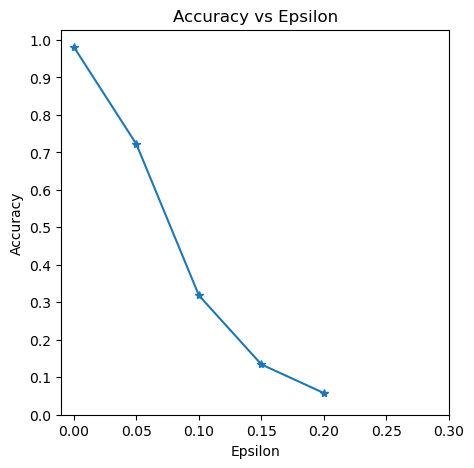

In [10]:
# Plot accuracy vs epsilon
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

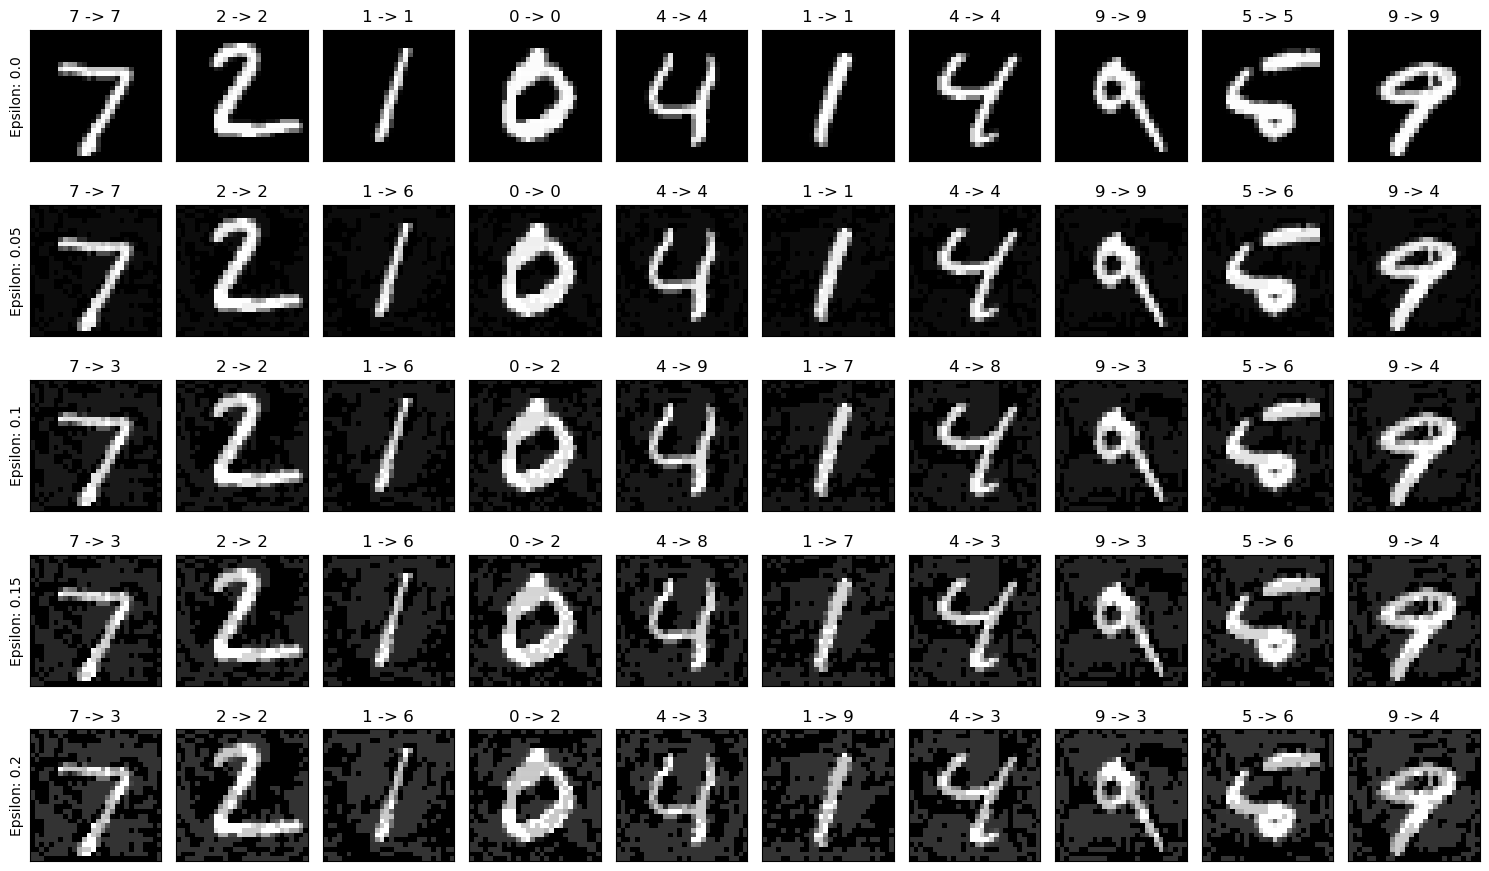

In [11]:
# Each row shows several adversarial sample for a given epsilon value
fig, axes = plt.subplots(nrows=len(epsilons), ncols=len(examples[0]), figsize=(3*len(epsilons), 9))

for i in range(len(epsilons)):
    for j in range(len(examples[0])):
        axes[i, j].imshow(examples[i][j][4].squeeze(), cmap='gray')
        axes[i, j].set_title(f"{examples[i][j][1]} -> {examples[i][j][2]}")
        if j == 0:
            axes[i, 0].set_ylabel(f"Epsilon: {epsilons[i]}")
        else:
            axes[i, j].set_ylabel("")
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.tight_layout()
plt.show()

## Thinking

1. How do you choose the value of $\epsilon$ in FGSM, and how does it affect the success of the attack?